# 1 An analysis of Indonesian tourist arrivals to Singapore

# 2 Set up

## 2.1 Import Libraries

In [995]:
# Import main libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
import numpy as np
import math

from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

#for modelling
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, PoissonRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, FunctionTransformer, MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import RocCurveDisplay
from scipy import special, stats

### Plot Settings

In [882]:
# Settings
pd.set_option("display.max_columns", 50)
sns.set_theme(style = 'white')

params = {'legend.fontsize': 'x-large',
                            'axes.labelsize': 'large',
                            'axes.titlesize':'xx-large',
                            'xtick.labelsize':'medium',
                            'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# colors
color_set = ['#494985', '#5286D9', '#69AEE6', '#DEA058', '#CB660D']
pal_general = sns.set_palette(sns.color_palette(color_set, 5))

### Useful Functions

In [884]:
## Useful functions to be used

# Function to plot histogram
def plot_histogram(df, features, height_multiple, rotation = 45):
    """A function to plot a series of histograms.
    df: dataframe to plot
    features: list of feature names for X axis
    height_multiple: ratio of plot height to width"""
    
    num_plots = len(features)
    num_cols = 2
    num_rows = math.ceil(num_plots/num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize = (20, num_rows*(20/num_cols*height_multiple)))
    
    # loop through rows and columns and plot histogram
    predictor_count = 0
    for row in range(num_rows):
        for col in range(num_cols):
            if predictor_count < len(features):
                sns.histplot(data = df, x = features[predictor_count], ax = axs[row, col], alpha = 1)
                axs[row, col].xaxis.set_tick_params(rotation=rotation)

                predictor_count += 1
            else:
                break
        
    plt.tight_layout()
    
# Function to create population pyramid
def population_pyramid(data, category, age_map, male_color, female_color):
    
    female = pov_dict[category][pov_dict[category]['gender'] == 'Female'].groupby('age_map').count().reset_index()[['age_map', 'Total']]
    male = pov_dict[category][pov_dict[category]['gender'] == 'Male'].groupby('age_map').count().reset_index()[['age_map', 'Total']]
    
    highest_x = max([female['Total'].max(), male['Total'].max()])
    
    female_percentage = str(round(data['gender'].value_counts(normalize = True).loc['Female']*100)) + '%'
    male_percentage = str(round(data['gender'].value_counts(normalize = True).loc['Male']*100)) + '%'
    
    # plot male
    plt.figure(figsize = (10, 5))
    plt.subplot(1,2,1)
    bar1 = sns.barplot(data = male, x = 'Total', y = 'age_map', orient='h', color = male_color)
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.ylim(-1,12)
    sns.despine(bottom=True, left=True)
    plt.ylabel("")
    plt.yticks(ticks = [k for k, v in age_map.items()], labels = [v for k, v in age_map.items()])
    plt.xlabel(f"Male({male_percentage})", fontsize = 'large')
    plt.xlim(highest_x, 0)
    plt.title(category)
    
    # plot female
    plt.subplot(1,2,2)
    sns.barplot(data = female, x = 'Total', y = 'age_map', orient='h', color = female_color)
    plt.gca().invert_yaxis()
    plt.ylim(-1,12)
    sns.despine(bottom=True, left=True)
    plt.yticks([])
    plt.ylabel("")
    plt.xlabel("")
    plt.xlabel(f"Female({female_percentage})", fontsize = 'large')
    plt.xlim(0, highest_x)

    plt.tight_layout()
    
# funtion to perform hyperparameter tuning 
def hyperparam_tuning(feature_sets, response, estimators, use_PCA, useSMOTE, scaler, scoring, refit, cv, verbose):
    """
    Function to find best parameter from a set of feature sets, vectorizers and estimators through gridsearch
    feature_sets = feature sets dictionary in the format {index:dataframe}
    response = Series consisting of the feature labels
    estimators = Estimator dictionary containing estimator instance and parameters
    PCA = True or False - whether to apply PCA before prediction
    scaler = Pass in a scaler instance
    scoring = str of the scoring metric to use for gridsearch
    cv = number of cross validation folds
    verbose= The level of detail of information to print while performing fits
    ""
    """
    grid_search_result = []

    # loop through the feature sets dict
    for i, feature_set in feature_sets.items():
        print(f"------------------- Feature Set {i} --------------------")
        X = feature_set
        y = response
        #----------------------------------------------------------------------------------
        # loop through the estimators dict
        for estimator_name, estimator_info in estimators.items():
            grid_search_result_row = {} # stores best result of a estimator

            if use_PCA == True and useSMOTE == False: 
                pipe = Pipeline(steps=[('scaler', scaler),
                                       ('PCA', PCA(n_components = 0.98)), 
                                       (estimator_name, estimator_info['estimator'])])
            elif use_PCA == True and useSMOTE == True: 
                pipe = ImbPipeline(steps=[('scaler', scaler),
                                       ('PCA', PCA(n_components = 0.98)),
                                       ('sampling', SMOTE(random_state = 42)),
                                       (estimator_name, estimator_info['estimator'])])
            elif use_PCA == False and useSMOTE == True: 
                pipe = ImbPipeline(steps=[('scaler', scaler),
                                       ('sampling', SMOTE(random_state = 42)),
                                       (estimator_name, estimator_info['estimator'])])
            else: 
                pipe = Pipeline(steps=[('scaler', scaler),
                                       (estimator_name, estimator_info['estimator'])])
                
            # merge the vectorizer and estimator params into a single param grid
            param_grid = estimator_info['params']

            # create gridsearchcv object
            grid_search = GridSearchCV(pipe, param_grid = param_grid, 
                                       scoring = scoring, refit = refit ,verbose = verbose, cv=cv)
            grid_search.fit(X, y) # fit gs object

            # collect the important results
            grid_search_result_row["feature_set"] = i
            grid_search_result_row["estimator"] = estimator_name
            grid_search_result_row["grid search object"] = grid_search
            grid_search_result_row["best estimator"] = grid_search.best_estimator_
            grid_search_result_row["best score"] = grid_search.best_score_
            grid_search_result_row["best params"] = grid_search.best_params_

            print(f"{estimator_name} best {refit} score:", grid_search.best_score_)

            grid_search_result.append(grid_search_result_row)
        
    return grid_search_result

# Function to perform boxcox transformation with the optimal lambda value
def boxcox_transform(col):
    lambdas = np.linspace(0,1,101) # 101 values from 0 to 1
    current_skew = 100000000000000 # initiate skew with an arbitrarily large value
    transformed_col = 0
    selected_lambda = 0
    
    # iterate through the lambdas and find the lambda that minimizes skewness
    for lamb in lambdas:
        transformed_col_temp = special.boxcox1p(col, lamb)
        skew = transformed_col_temp.skew()
        if abs(skew) < abs(current_skew): # find the lowest skew by comparing current skew with the new skew
            current_skew = skew
            transformed_col = transformed_col_temp
            selected_lambda = lamb
    if col.name == "non_medical ($)_per_day": # we need the lambda for SalePrice in order to reverse box cox later
        y_lambda.append(selected_lambda) # add best lamnda 
    return transformed_col            

# function to plot histogram with kde
def plot_hist(df_numeric):
    num_plots = len(df_numeric.columns)
    num_cols = 2
    num_rows = math.ceil(num_plots/num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize = (20, num_rows*(20/num_cols-0.5)))
    
    # loop through rows and columns and plot scatter plot
    predictor_count = 0
    for row in range(num_rows):
        for col in range(num_cols):
            if predictor_count < num_plots:
                sns.histplot(x = df_numeric.iloc[:,predictor_count], ax = axs[row, col], kde = True)
                axs[row, col].set_title(f"Skewness: {round(df_numeric.iloc[:,predictor_count].skew(), 2)}")
                predictor_count += 1
            else:
                break
        
    plt.tight_layout()

## 2.2 Data Preparation

### 2.2.1 Import Dataset

In [885]:
df_original = pd.read_excel("dataset/Mock dataset.xlsx")

### 2.2.2 Dataset Overview

In [1091]:
df_original.sort_values('case').head(5)

,case,quarter,R.mth,age,country,1st time visitor,nbr visit past 3 yrs,mode of arrival,carrier,purpose of visit,purpose of visit_Grp,pov6a,Mono-SIN,Last Port,Next Port,length of stay,Travel Type,gender,marital status,companion_1,companion_2,companion_3,companion_4,companion_5,companion_6,accomodation ($),shop ($),fnb ($),transport ($),medical ($),others ($),Total
0,4,1,1,30-34 yrs,Indonesia,No,50,Sea,NaN,"Others - Personal (e.g. weddings, funerals, etc)",Leisure,Others/ Refused,Multi-Destination,No,Yes,0.5,FIT,Male,married,Alone,None,None,None,None,None,0.000000,156.552823,6.260814,31.304069,0.0,0.0,194.117706
1,59,1,1,50-54 yrs,Indonesia,No,18,Air,Valuair (VLU),Outpatient consultation/treatment,Healthcare,Healthcare,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,231.276669,606.552823,355.810260,160.114617,1750.0,0.0,3103.754370
2,83,1,1,40-44 yrs,Indonesia,No,3,Air,Singapore Airlines Limited (SIA),General business purpose,Business,Business,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,996.268729,226.552823,1067.430781,355.810260,0.0,0.0,2646.062594
3,250,1,1,20-24 yrs,Indonesia,No,11,Sea,NaN,Visiting friends/relatives,Leisure,Leisure,Multi-Destination,No,Yes,1.0,FIT,Female,married,Parents/ Parents-in-law,None,None,None,None,None,0.000000,356.552823,31.304069,78.260173,0.0,0.0,466.117064
4,260,1,1,55-59 yrs,Indonesia,No,9,Air,Garuda Indonesia (GIA),Outpatient consultation/treatment,Healthcare,Healthcare,Mono-SIN,No,No,2.0,FIT,Female,married,Spouse,None,None,None,None,None,142.324104,156.552823,177.905130,88.952565,2000.0,0.0,2565.734622


The dataset consists of **2952 rows with 32 features**. It contains information on tourist arrivals from **Indonesia**.

In [887]:
# Get a preview of the dataset
print("Shape of dataframe: ", df_original.shape)
print(f"Countries: {df_original['country'].unique()}")
df_original.head()

Shape of dataframe:  (2952, 32)
Countries: ['Indonesia']


,case,quarter,R.mth,age,country,1st time visitor,nbr visit past 3 yrs,mode of arrival,carrier,purpose of visit,purpose of visit_Grp,pov6a,Mono-SIN,Last Port,Next Port,length of stay,Travel Type,gender,marital status,companion_1,companion_2,companion_3,companion_4,companion_5,companion_6,accomodation ($),shop ($),fnb ($),transport ($),medical ($),others ($),Total
0,4,1,1,30-34 yrs,Indonesia,No,50,Sea,NaN,"Others - Personal (e.g. weddings, funerals, etc)",Leisure,Others/ Refused,Multi-Destination,No,Yes,day tripper,FIT,Male,married,Alone,NaN,NaN,NaN,NaN,NaN,0.000000,156.552823,6.260814,31.304069,0.0,0.0,194.117706
1,59,1,1,50-54 yrs,Indonesia,No,18,Air,Valuair (VLU),Outpatient consultation/treatment,Healthcare,Healthcare,Mono-SIN,No,No,1,FIT,Male,married,Alone,NaN,NaN,NaN,NaN,NaN,231.276669,606.552823,355.810260,160.114617,1750.0,0.0,3103.754370
2,83,1,1,40-44 yrs,Indonesia,No,3,Air,Singapore Airlines Limited (SIA),General business purpose,Business,Business,Mono-SIN,No,No,1,FIT,Male,married,Alone,NaN,NaN,NaN,NaN,NaN,996.268729,226.552823,1067.430781,355.810260,0.0,0.0,2646.062594
3,250,1,1,20-24 yrs,Indonesia,No,11,Sea,NaN,Visiting friends/relatives,Leisure,Leisure,Multi-Destination,No,Yes,1,FIT,Female,married,Parents/ Parents-in-law,NaN,NaN,NaN,NaN,NaN,0.000000,356.552823,31.304069,78.260173,0.0,0.0,466.117064
4,260,1,1,55-59 yrs,Indonesia,No,9,Air,Garuda Indonesia (GIA),Outpatient consultation/treatment,Healthcare,Healthcare,Mono-SIN,No,No,2,FIT,Female,married,Spouse,NaN,NaN,NaN,NaN,NaN,142.324104,156.552823,177.905130,88.952565,2000.0,0.0,2565.734622


### 2.2.3 Datatype Conversion

In [888]:
# Look at the datatypes, change datatypes if necessary
pd.DataFrame(df_original.dtypes).T

,case,quarter,R.mth,age,country,1st time visitor,nbr visit past 3 yrs,mode of arrival,carrier,purpose of visit,purpose of visit_Grp,pov6a,Mono-SIN,Last Port,Next Port,length of stay,Travel Type,gender,marital status,companion_1,companion_2,companion_3,companion_4,companion_5,companion_6,accomodation ($),shop ($),fnb ($),transport ($),medical ($),others ($),Total
0,int64,int64,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64


From the brief view of data types. The `length of stay` is of object datatype, which does not seem convenient to work with. Let us examine the reason.

In [1090]:
# We will see the number of unique values for the 'length of stay' column
df_original['length of stay'].unique()

array([ 0.5,  1. ,  2. ,  4. ,  5. ,  3. ,  7. ,  6. , 12. , 10. , 16. ,
       27. ,  8. , 14. , 13. , 20. , 21. , 24. , 17. , 18. , 28. , 11. ,
       25. , 26. , 29. , 33. , 19. , 23. , 22. , 30. , 36. , 43. ,  9. ,
       15. , 31. , 53. , 58. , 32. , 37. , 60. , 44. , 57. , 34. , 35. ,
       38. , 55. , 39. ])

Seems that there are rows containing **'day tripper'** value. These are visitors who did not stay overnight. We will represent these with a value of **0.5** and convert to the integer datatype so the column is easier to work with.

In [890]:
# Create a new dataframe since we do not want to overwrite the original dataframe. Then replace 'day tripper' with 0.5
df = df_original
df['length of stay'] = (df['length of stay'].replace({'day tripper':0.5})).astype(float)

In [891]:
# See the unique vales again
print("Datatype: ", df['length of stay'].dtype)
print("Unique Values: ", df['length of stay'].unique())

Datatype:  float64
Unique Values:  [ 0.5  1.   2.   4.   5.   3.   7.   6.  12.  10.  16.  27.   8.  14.
 13.  20.  21.  24.  17.  18.  28.  11.  25.  26.  29.  33.  19.  23.
 22.  30.  36.  43.   9.  15.  31.  53.  58.  32.  37.  60.  44.  57.
 34.  35.  38.  55.  39. ]


Now that looks about right.

### 2.2.4 Missing Values

Now we shall see if there are missing values present in the dataset.

In [892]:
pd.DataFrame(df.isna().sum()[df.isna().sum()>0]).sort_values(by = 0, ascending = False).rename(columns = {0:'Missing count'})

,Missing count
companion_6,2952
companion_5,2945
companion_4,2926
companion_3,2820
companion_2,2508
carrier,1501
nbr visit past 3 yrs,334
Last Port,1
Next Port,1
marital status,1


#### Missing Value for companion columns

For companion columns, the missing values are likely due to the fact that the information had already been filled in in the `companion_1` column. Hence, we will fill the missing values with 'None' to signify that there are no more companions.

For the 1 missing value for `companion_1` column. We can assume that it is of the value 'Alone'.

In [893]:
# first we fill the missing value for companion_1 column as 'Alone'
df['companion_1'] = df['companion_1'].fillna('Alone')
print("Null value for companion_1: ", df['companion_1'].isnull().sum())

Null value for companion_1:  0


In [894]:
# Then we fill the other companion columns as None
companion_cols = ['companion_6','companion_5','companion_4','companion_3','companion_2']
df[companion_cols] = df[companion_cols].fillna('None')
print("Null value for companion columns:", '\n', df[companion_cols].isnull().sum())

Null value for companion columns: 
 companion_6    0
companion_5    0
companion_4    0
companion_3    0
companion_2    0
dtype: int64


#### Missing value for carrier columns

For the air carriers, we will examine if the missing values are all a result of travellers travelling by sea or land.

In [895]:
print("Number of travel arrivals by land or sea, which carrier as null value: ", df[((df['mode of arrival'] == "Sea") | (df['mode of arrival'] == "Land")) & (df['carrier'].isnull())].shape[0])

Number of travel arrivals by land or sea, which carrier as null value:  1501


It is indeed the case that those arrivals by sea or land has missing values for `carrier` column. We will fill these missing values with either **"Land"** or **"Sea"**.

In [896]:
def fill_missing_carrier(row):
    if row['mode of arrival'] != "Air":
        row["carrier"] = row['mode of arrival']
    return row
df = df.apply(fill_missing_carrier, axis = 1)

print("Number of missing values for carrier column: ", df['carrier'].isnull().sum())

Number of missing values for carrier column:  0


We have filled all missing values for `carrier` with either "Land" or "Sea".

#### Missing values for "nbr visit past 3 yrs" column

Let us first see the unique values for this column. We notice that the non-numeric values include "nan" (missing value) and "Many times". 

In [897]:
# See unique values 
df["nbr visit past 3 yrs"].unique()

array([50, 18, 3, 11, 9, nan, 5, 0, 2, 7, 6, 100, 20, 17, 35, 1, 4, 10, 8,
       25, 12, 15, 30, 60, 40, 36, 300, 150, 90, 250, 120, 200, 70, 600,
       156, 45, 72, 48, 780, 252, 312, 22, 24, 23, 108, 42, 96, 104, 21,
       14, 54, 144, 75, 16, 33, 26, 57, 13, 55, 228, 360, 84, 110,
       'Many times', 66, 180, 80, 130, 500], dtype=object)

In [898]:
# We have 334 missing values
df["nbr visit past 3 yrs"].isnull().sum()

334

Let us examine if the missing values are a result of the visitor having not visited the country before.

In [899]:
print("Missing value but not first time visitor or Visited 'Many times': ", df[((df["nbr visit past 3 yrs"].isnull()) & (df['1st time visitor'] == 'No')) | (df["nbr visit past 3 yrs"] == 'Many times')].shape[0])
print("Missing value and first time visitor: ", df[(df["nbr visit past 3 yrs"].isnull()) & (df['1st time visitor'] == 'Yes')].shape[0])

Missing value but not first time visitor or Visited 'Many times':  4
Missing value and first time visitor:  332


1. We see that missing values which are not first time visitors and those that filled "Many times" only have 4 records. 
    - For these cases, since there are only 4 records (0.14% of the dataset). We will **drop** these records.


2. The majority of the missing values are those which are supposed to be 0.
    - For these cases, we will **fill missing values with 0**.

In [900]:
# Drop the 4 records
df = df[~(((df["nbr visit past 3 yrs"].isnull()) & (df['1st time visitor'] == 'No')) | (df["nbr visit past 3 yrs"] == 'Many times'))]

In [901]:
# Fill the rest with 0
df["nbr visit past 3 yrs"] = df["nbr visit past 3 yrs"].fillna(0)

In [902]:
print("No. of missing values for 'nbr visit past 3 yrs': ", df["nbr visit past 3 yrs"].isnull().sum())

No. of missing values for 'nbr visit past 3 yrs':  0


#### Missing value for all other columns

For other columns with missing values, it is most likely due to unfilled information during data entry. We will replace the null values with "Not Stated".

In [903]:
missing_cols = pd.DataFrame(df.isna().sum()[df.isna().sum()>0]).index
missing_cols

Index(['Last Port', 'Next Port', 'marital status'], dtype='object')

In [904]:
missing_cols = pd.DataFrame(df.isna().sum()[df.isna().sum()>0]).index
df[missing_cols] = df[missing_cols].fillna("Not Stated")

In [905]:
print("Final number of missing values for dataset: ", df.isnull().sum().sum())

Final number of missing values for dataset:  0


Great, we have dealt with all missing values.

### 2.2.5 Engineer New Features

Next, we will come up with some new features base on existing features, which will help us get more insights into the data.

#### Aggregating *companion* columns

The current companion columns are separated into 6 columns, we will aggregate these columns into a single column which will help us focus our analysis.

In [906]:
def companion_agg(row):
    # dict which maps relations
    family_vals = {"Alone": ['Alone'],
                    "Family": ['Parents', 'Grandparents', 'relatives', 'Children', 'Siblings'],
                   "Couple": ['Partner/ Boyfriend/ Girlfriend', 'Spouse'],
                   "Friends": ['Friends'],
                   "Business associates": ['Business associates/ Colleagues'],
                   "Others": ["Others"]}
    # generate string combination of all values
    combined = ''
    for col in [f"companion_{i}" for i in range(1,7)]:
        combined += row[col]
    # Populate value for "companions" column base on values for other companion columns
    
    row["companions"] = ""
    for grp, relations in family_vals.items():
        if row["companions"]=="":
            for r in relations:
                if r in combined:
                    row['companions'] = grp
                    #print(r, ": ", grp)
                    break
        else:
            break
    return row
    
df = df.apply(companion_agg, axis = 1)

In [907]:
df.head(3)

,case,quarter,R.mth,age,country,1st time visitor,nbr visit past 3 yrs,mode of arrival,carrier,purpose of visit,purpose of visit_Grp,pov6a,Mono-SIN,Last Port,Next Port,length of stay,Travel Type,gender,marital status,companion_1,companion_2,companion_3,companion_4,companion_5,companion_6,accomodation ($),shop ($),fnb ($),transport ($),medical ($),others ($),Total,companions
0,4,1,1,30-34 yrs,Indonesia,No,50,Sea,Sea,"Others - Personal (e.g. weddings, funerals, etc)",Leisure,Others/ Refused,Multi-Destination,No,Yes,0.5,FIT,Male,married,Alone,None,None,None,None,None,0.000000,156.552823,6.260814,31.304069,0.0,0.0,194.117706,Alone
1,59,1,1,50-54 yrs,Indonesia,No,18,Air,Valuair (VLU),Outpatient consultation/treatment,Healthcare,Healthcare,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,231.276669,606.552823,355.810260,160.114617,1750.0,0.0,3103.754370,Alone
2,83,1,1,40-44 yrs,Indonesia,No,3,Air,Singapore Airlines Limited (SIA),General business purpose,Business,Business,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,996.268729,226.552823,1067.430781,355.810260,0.0,0.0,2646.062594,Alone


#### Aggregate purpose of visit

Next, we shall create a new column by aggregating the column `purpose of visit`. This is to strike a balance between the large number of categories of the `purpose of visit` column and the over simplied categories of the `pov6a` column.

In [908]:
# First, create a column which combines 'purpose of visit' and 'pov6a'
df['pov_temp'] = df['pov6a'] + '-' + df['purpose of visit']
df['pov_temp'].value_counts()

# Then map the individual categories into aggregated categories
df_pov_dict = {'Leisure-Rest & Relax': ['Leisure-Holiday/ Rest & Relax', 'Leisure-To shop/attend shopping events in Singapore',
                                       'Leisure-To take or join a reginal or international cruise', 'Leisure-Sightseeing/ Attractions',
                                       'Leisure-IR (e.g. MBS, RWS)', 'Leisure-To experience the food/food events in Singapore',
                                       'Leisure-Performing Arts', 'Business-Company sponsored holiday'],
              'Leisure-Visit': ['Leisure-Visiting friends/relatives', 'Leisure-Visiting an international student studying in Singapore',
                               'Accompanying Pax-Accompaning an international student studying in Singapore'],
               'Leisure-Stopover': ['Leisure-Stopover'],
              'Business-General business purpose': ['Business-General business purpose', 'Accompanying Pax-Accompanying a business visitor'],
              'Business-Meetings and conventions': ['Business-Corporate/business meetings', 'Business-Exhibition/Trade show', 
                                                    'Business-Convention/conference'],
              'Healthcare-Consultation/treatment': ['Healthcare-Outpatient consultation/treatment', 'Healthcare-In-patient treatment', 
                                                    'Healthcare-Day-surgery'],
              'Healthcare-Accompanying': ['Accompanying Pax-Accompanying a Healthcare/medical visitor for Outpatient consultation/treat',
                                         'Accompanying Pax-Accompanying a Healthcare/medical visitor for In-patient treatment',
                                         'Accompanying Pax-Accompanying a Healthcare/medical visitor for Day surgery'],
              'Education-Student programs': ['Education-Study mission', 'Education-Student enrichment programmes', 'Education-School trips'],
              'Education-Training': ['Education-In-house company training', 'Education-Executive training, including training workshops and seminar',
                                    'Education-Skills development/skills training/vocational training'],
              'Others-Personal events': ['Others/ Refused-Others - Personal (e.g. weddings, funerals, etc)'],
              'Others-Work related': ['Others/ Refused-Others - Work Related (e.g. visa, insurance, etc)'],
              'Others-Enquiry on services': ['Leisure-Gathering informations on healthcare services in Singapore', 'Leisure-Gathering informations on the Education services in Singapor']}

cols = list(df.columns)+['pov_categorized']

# Then, write a function to create a new column 'pov_categorized' which is populated according to values from the 'pov_temp' column
def pov_agg(row):
    for k, v in df_pov_dict.items():
        if row['pov_temp'] in v:
            row['pov_categorized'] = k
            break
    return row

df = df.apply(pov_agg, axis =1)[cols]
df.head(3)

,case,quarter,R.mth,age,country,1st time visitor,nbr visit past 3 yrs,mode of arrival,carrier,purpose of visit,purpose of visit_Grp,pov6a,Mono-SIN,Last Port,Next Port,length of stay,Travel Type,gender,marital status,companion_1,companion_2,companion_3,companion_4,companion_5,companion_6,accomodation ($),shop ($),fnb ($),transport ($),medical ($),others ($),Total,companions,pov_temp,pov_categorized
0,4,1,1,30-34 yrs,Indonesia,No,50,Sea,Sea,"Others - Personal (e.g. weddings, funerals, etc)",Leisure,Others/ Refused,Multi-Destination,No,Yes,0.5,FIT,Male,married,Alone,None,None,None,None,None,0.000000,156.552823,6.260814,31.304069,0.0,0.0,194.117706,Alone,Others/ Refused-Others - Personal (e.g. weddin...,Others-Personal events
1,59,1,1,50-54 yrs,Indonesia,No,18,Air,Valuair (VLU),Outpatient consultation/treatment,Healthcare,Healthcare,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,231.276669,606.552823,355.810260,160.114617,1750.0,0.0,3103.754370,Alone,Healthcare-Outpatient consultation/treatment,Healthcare-Consultation/treatment
2,83,1,1,40-44 yrs,Indonesia,No,3,Air,Singapore Airlines Limited (SIA),General business purpose,Business,Business,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,996.268729,226.552823,1067.430781,355.810260,0.0,0.0,2646.062594,Alone,Business-General business purpose,Business-General business purpose


In [909]:
# Create column for large categories
df['pov_categorized_general'] = df['pov_categorized'].str.split('-').str[0]

In [910]:
# Create mapping int values
cols = list(df.columns)+['pov_categorized_int']

pov_int_map = {v: i for i, v in enumerate(df['pov_categorized'].value_counts().index)}
def map_pov_int(row):
    row['pov_categorized_int'] = pov_int_map[row['pov_categorized']]
    return row
df = df.apply(map_pov_int, axis =1)[cols]
df.head(3)

,case,quarter,R.mth,age,country,1st time visitor,nbr visit past 3 yrs,mode of arrival,carrier,purpose of visit,purpose of visit_Grp,pov6a,Mono-SIN,Last Port,Next Port,length of stay,Travel Type,gender,marital status,companion_1,companion_2,companion_3,companion_4,companion_5,companion_6,accomodation ($),shop ($),fnb ($),transport ($),medical ($),others ($),Total,companions,pov_temp,pov_categorized,pov_categorized_general,pov_categorized_int
0,4,1,1,30-34 yrs,Indonesia,No,50,Sea,Sea,"Others - Personal (e.g. weddings, funerals, etc)",Leisure,Others/ Refused,Multi-Destination,No,Yes,0.5,FIT,Male,married,Alone,None,None,None,None,None,0.000000,156.552823,6.260814,31.304069,0.0,0.0,194.117706,Alone,Others/ Refused-Others - Personal (e.g. weddin...,Others-Personal events,Others,4
1,59,1,1,50-54 yrs,Indonesia,No,18,Air,Valuair (VLU),Outpatient consultation/treatment,Healthcare,Healthcare,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,231.276669,606.552823,355.810260,160.114617,1750.0,0.0,3103.754370,Alone,Healthcare-Outpatient consultation/treatment,Healthcare-Consultation/treatment,Healthcare,3
2,83,1,1,40-44 yrs,Indonesia,No,3,Air,Singapore Airlines Limited (SIA),General business purpose,Business,Business,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,996.268729,226.552823,1067.430781,355.810260,0.0,0.0,2646.062594,Alone,Business-General business purpose,Business-General business purpose,Business,2


#### Aggregate *carrier* column

We can also aggregate the airlines by the type of airlines, i.e. national carriers, regional carriers, low-cost carriers.

In [911]:
# We will do the aggregation for the carrier column
# First, map the original values to the new category in the dictionary
carriers_dict = {"Sea": ["Sea"], "Land": ["Land"], 
                "Low Cost Carrier": ['AirAsia Berhad (AXM)', 'Lion Airlines (LNI)', 'Valuair (VLU)',
                                    'Indonesia AirAsia (AWQ)', 'Jetstar Asia Airways (JSA)', 'Tiger Airways (TGW)',
                                    'Freedom Air', 'Jetstar Airways International (JST)', 'Cebu Pacific Air (CEB)'],
                 "Regional Carrier": ['Batavia Air (BTV)', 'SilkAir (Singapore) Pte Limited (SLK)', ''],
                "National Carrier": ['Garuda Indonesia (GIA)', 
                                     'China Airlines Limited (CAL)', 'Lufthansa German Airlines AG (DLH)',
                                    'Cathay Pacific Airways Limited (CPA)', 'Philippine Airlines Inc (PAL)',
                                    'Thai Airways International Public Co Ltd (THA)', 'Malaysia Airlines (MAS)'
                                    'Qantas Airways Limited (QFA)', 'KLM-Royal Dutch Airlines (KLM)', 'Air China International Corporation (CCA)',
                                    'Myanmar Airways International (UBA)', 'SriLankan Airlines Limited (ALK)', 'Turkish Airlines (THY)', 'China Southern Airlines (CSN)',
                                    'China Eastern Airlines (CES)', 'Xiamen Airlines (CXA)', 'Asiana Airlines (AAR)'],
                 "Premium Carrier": ['United Airlines Inc (UAL)', 'Qatar Airways (QTR)', 'All Nippon Airways Co Limited (ANA)',
                                    'Singapore Airlines Limited (SIA)', 'Delta Airlines (DAL)'],
                'Others': ['Others', 'NA/Not Stated']}

cols = list(df.columns)+['carrier_category']
# Next, function to create a new column: carrier_categor, and populate the values
def carrier_agg(row):
    for k, v in carriers_dict.items():
        if row['carrier'] in v:
            row['carrier_category'] = k
            break
    return row

df = df.apply(carrier_agg, axis =1)[cols]
df.head(3)

,case,quarter,R.mth,age,country,1st time visitor,nbr visit past 3 yrs,mode of arrival,carrier,purpose of visit,purpose of visit_Grp,pov6a,Mono-SIN,Last Port,Next Port,length of stay,Travel Type,gender,marital status,companion_1,companion_2,companion_3,companion_4,companion_5,companion_6,accomodation ($),shop ($),fnb ($),transport ($),medical ($),others ($),Total,companions,pov_temp,pov_categorized,pov_categorized_general,pov_categorized_int,carrier_category
0,4,1,1,30-34 yrs,Indonesia,No,50,Sea,Sea,"Others - Personal (e.g. weddings, funerals, etc)",Leisure,Others/ Refused,Multi-Destination,No,Yes,0.5,FIT,Male,married,Alone,None,None,None,None,None,0.000000,156.552823,6.260814,31.304069,0.0,0.0,194.117706,Alone,Others/ Refused-Others - Personal (e.g. weddin...,Others-Personal events,Others,4,Sea
1,59,1,1,50-54 yrs,Indonesia,No,18,Air,Valuair (VLU),Outpatient consultation/treatment,Healthcare,Healthcare,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,231.276669,606.552823,355.810260,160.114617,1750.0,0.0,3103.754370,Alone,Healthcare-Outpatient consultation/treatment,Healthcare-Consultation/treatment,Healthcare,3,Low Cost Carrier
2,83,1,1,40-44 yrs,Indonesia,No,3,Air,Singapore Airlines Limited (SIA),General business purpose,Business,Business,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,996.268729,226.552823,1067.430781,355.810260,0.0,0.0,2646.062594,Alone,Business-General business purpose,Business-General business purpose,Business,2,Premium Carrier


#### Mapping Age Groups to Integer

In [912]:
age_cats = np.sort(df['age'].unique())
age_map = {i: age_cats[i] for i in range(len(age_cats))}

cols = list(df.columns)+['age_map']

def age_map_func(row):
    for k, v in age_map.items():
        if row['age'] in v:
            row['age_map'] = k
            break
    return row

df = df.apply(age_map_func, axis =1)[cols]
df.head(3)

,case,quarter,R.mth,age,country,1st time visitor,nbr visit past 3 yrs,mode of arrival,carrier,purpose of visit,purpose of visit_Grp,pov6a,Mono-SIN,Last Port,Next Port,length of stay,Travel Type,gender,marital status,companion_1,companion_2,companion_3,companion_4,companion_5,companion_6,accomodation ($),shop ($),fnb ($),transport ($),medical ($),others ($),Total,companions,pov_temp,pov_categorized,pov_categorized_general,pov_categorized_int,carrier_category,age_map
0,4,1,1,30-34 yrs,Indonesia,No,50,Sea,Sea,"Others - Personal (e.g. weddings, funerals, etc)",Leisure,Others/ Refused,Multi-Destination,No,Yes,0.5,FIT,Male,married,Alone,None,None,None,None,None,0.000000,156.552823,6.260814,31.304069,0.0,0.0,194.117706,Alone,Others/ Refused-Others - Personal (e.g. weddin...,Others-Personal events,Others,4,Sea,4
1,59,1,1,50-54 yrs,Indonesia,No,18,Air,Valuair (VLU),Outpatient consultation/treatment,Healthcare,Healthcare,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,231.276669,606.552823,355.810260,160.114617,1750.0,0.0,3103.754370,Alone,Healthcare-Outpatient consultation/treatment,Healthcare-Consultation/treatment,Healthcare,3,Low Cost Carrier,8
2,83,1,1,40-44 yrs,Indonesia,No,3,Air,Singapore Airlines Limited (SIA),General business purpose,Business,Business,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,996.268729,226.552823,1067.430781,355.810260,0.0,0.0,2646.062594,Alone,Business-General business purpose,Business-General business purpose,Business,2,Premium Carrier,6


#### Aggregating Number of prior visits

We will also create a column which maps the number of visits in the past 3 years to categorical terms releveant to our analysis, i.e. Once a week, Once a month, etc.

In [913]:
cols = list(df.columns)+['nbr_visit_map']

def num_visit_map(row):
    num_half_weeks = (365*3)/3.5
    num_weeks = (365*3)/7
    num_fortnights = (365*3)/14
    num_months = 3 * 12
    num_quarters = 3 * 4
    num_half_year = 3 * 2
    num_year = 3
    
    
    if row["nbr visit past 3 yrs"] == 0:
        row['nbr_visit_map'] = 'First time visitor'
    elif row["nbr visit past 3 yrs"] // num_half_weeks >= 0.75: 
        row['nbr_visit_map'] = 'Twice per week'
    elif row["nbr visit past 3 yrs"] // num_weeks >= 0.75: 
        row['nbr_visit_map'] = 'Once per week'
    elif row["nbr visit past 3 yrs"] // num_fortnights >= 0.75: 
        row['nbr_visit_map'] = 'Once per fortnight'
    elif row["nbr visit past 3 yrs"] // num_months >= 0.75: 
        row['nbr_visit_map'] = 'Once per month'
    elif row["nbr visit past 3 yrs"] // num_quarters >= 0.75: 
        row['nbr_visit_map'] = 'Once per quarter'
    elif row["nbr visit past 3 yrs"] // num_half_year >= 0.75: 
        row['nbr_visit_map'] = 'Once per half year'
    elif row["nbr visit past 3 yrs"] // num_year >= 0.75: 
        row['nbr_visit_map'] = 'Once per year'
    else: 
        row['nbr_visit_map'] = 'A couple of times'
    return row

df = df.apply(num_visit_map, axis =1)[cols]
df.head(3)

,case,quarter,R.mth,age,country,1st time visitor,nbr visit past 3 yrs,mode of arrival,carrier,purpose of visit,purpose of visit_Grp,pov6a,Mono-SIN,Last Port,Next Port,length of stay,Travel Type,gender,marital status,companion_1,companion_2,companion_3,companion_4,companion_5,companion_6,accomodation ($),shop ($),fnb ($),transport ($),medical ($),others ($),Total,companions,pov_temp,pov_categorized,pov_categorized_general,pov_categorized_int,carrier_category,age_map,nbr_visit_map
0,4,1,1,30-34 yrs,Indonesia,No,50,Sea,Sea,"Others - Personal (e.g. weddings, funerals, etc)",Leisure,Others/ Refused,Multi-Destination,No,Yes,0.5,FIT,Male,married,Alone,None,None,None,None,None,0.000000,156.552823,6.260814,31.304069,0.0,0.0,194.117706,Alone,Others/ Refused-Others - Personal (e.g. weddin...,Others-Personal events,Others,4,Sea,4,Once per month
1,59,1,1,50-54 yrs,Indonesia,No,18,Air,Valuair (VLU),Outpatient consultation/treatment,Healthcare,Healthcare,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,231.276669,606.552823,355.810260,160.114617,1750.0,0.0,3103.754370,Alone,Healthcare-Outpatient consultation/treatment,Healthcare-Consultation/treatment,Healthcare,3,Low Cost Carrier,8,Once per quarter
2,83,1,1,40-44 yrs,Indonesia,No,3,Air,Singapore Airlines Limited (SIA),General business purpose,Business,Business,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,996.268729,226.552823,1067.430781,355.810260,0.0,0.0,2646.062594,Alone,Business-General business purpose,Business-General business purpose,Business,2,Premium Carrier,6,Once per year


#### Create per day spending

In [914]:
for col in ['accomodation ($)', 'shop ($)', 'fnb ($)', 'transport ($)', 'medical ($)', 'others ($)', 'Total']:
    df[f'{col}_per_day'] = df[col]/df['length of stay']
df['non_medical ($)_per_day'] = df['Total_per_day'] - df['medical ($)_per_day']
df['non_medical_total'] = df['Total'] -  df['medical ($)']

In [915]:
df.head(3)

,case,quarter,R.mth,age,country,1st time visitor,nbr visit past 3 yrs,mode of arrival,carrier,purpose of visit,purpose of visit_Grp,pov6a,Mono-SIN,Last Port,Next Port,length of stay,Travel Type,gender,marital status,companion_1,companion_2,companion_3,companion_4,companion_5,companion_6,accomodation ($),shop ($),fnb ($),transport ($),medical ($),others ($),Total,companions,pov_temp,pov_categorized,pov_categorized_general,pov_categorized_int,carrier_category,age_map,nbr_visit_map,accomodation ($)_per_day,shop ($)_per_day,fnb ($)_per_day,transport ($)_per_day,medical ($)_per_day,others ($)_per_day,Total_per_day,non_medical ($)_per_day,non_medical_total
0,4,1,1,30-34 yrs,Indonesia,No,50,Sea,Sea,"Others - Personal (e.g. weddings, funerals, etc)",Leisure,Others/ Refused,Multi-Destination,No,Yes,0.5,FIT,Male,married,Alone,None,None,None,None,None,0.000000,156.552823,6.260814,31.304069,0.0,0.0,194.117706,Alone,Others/ Refused-Others - Personal (e.g. weddin...,Others-Personal events,Others,4,Sea,4,Once per month,0.000000,313.105645,12.521628,62.608138,0.0,0.0,388.235411,388.235411,194.117706
1,59,1,1,50-54 yrs,Indonesia,No,18,Air,Valuair (VLU),Outpatient consultation/treatment,Healthcare,Healthcare,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,231.276669,606.552823,355.810260,160.114617,1750.0,0.0,3103.754370,Alone,Healthcare-Outpatient consultation/treatment,Healthcare-Consultation/treatment,Healthcare,3,Low Cost Carrier,8,Once per quarter,231.276669,606.552823,355.810260,160.114617,1750.0,0.0,3103.754370,1353.754370,1353.754370
2,83,1,1,40-44 yrs,Indonesia,No,3,Air,Singapore Airlines Limited (SIA),General business purpose,Business,Business,Mono-SIN,No,No,1.0,FIT,Male,married,Alone,None,None,None,None,None,996.268729,226.552823,1067.430781,355.810260,0.0,0.0,2646.062594,Alone,Business-General business purpose,Business-General business purpose,Business,2,Premium Carrier,6,Once per year,996.268729,226.552823,1067.430781,355.810260,0.0,0.0,2646.062594,2646.062594,2646.062594


# 3 Problem Statement

## 3.1 Objective of Analysis

Develop profile groups of Indonesian visitors and understand their key characteristics so that STB can focus their market growing efforts to different groups of visitors, and provide better advice to local players to develop further capabilities.

## 3.2 Potential Stakeholders

**Singapore Tourism Board**

- Growing the Indonesian market
    - Design targeted marketing campaigns
      
- Industrial and capability development
    - Focused development of domestic industries and tourism capabilities 
    - Offer advice and incentive for local tourism players
    
**Local tourism sector**

- Such as **hospitality, airlines, cultural, commercial and tourism services**
    - benefit from understanding of customer profile
    - tailor services to enhance experience and derive value

# 4 Exploratory Data Analysis

## 4.1 Understanding Key Terms and Values

For this section, we seek to gain a basic understanding of key categories and values of our dataset.

In [916]:
# First, we will take a look at the key categories for categorical variables.
categorical_col_names = list(df.dtypes[df.dtypes == 'object'].index) # categorical column names
categorical_col_names.remove('carrier')
categorical_col_names.remove('purpose of visit')
categorical_col_names.remove('pov_temp')
categorical_col_names.append('age_map')
unique_vals = {name: df[name].unique() for name in categorical_col_names}

# View dataframe containing unique value for each 
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in unique_vals.items()]))

,age,country,1st time visitor,mode of arrival,purpose of visit_Grp,pov6a,Mono-SIN,Last Port,Next Port,Travel Type,gender,marital status,companion_1,companion_2,companion_3,companion_4,companion_5,companion_6,companions,pov_categorized,pov_categorized_general,carrier_category,nbr_visit_map,age_map
0,30-34 yrs,Indonesia,No,Sea,Leisure,Others/ Refused,Multi-Destination,No,Yes,FIT,Male,married,Alone,None,None,None,None,None,Alone,Others-Personal events,Others,Sea,Once per month,4.0
1,50-54 yrs,NaN,Yes,Air,Healthcare,Healthcare,Mono-SIN,Yes,No,Pkg,Female,single,Parents/ Parents-in-law,Children aged 0-7 yrs,Children aged 8-12 yrs,Siblings,Other relatives,NaN,Family,Healthcare-Consultation/treatment,Healthcare,Low Cost Carrier,Once per quarter,8.0
2,40-44 yrs,NaN,NaN,Land,Business,Business,Not Stated,Not Stated,Not Stated,F&E,NaN,divorced,Spouse,Grandparents/ Grandparents-in-law,Siblings,Children aged 13-19 yrs,Parents/ Parents-in-law,NaN,Couple,Business-General business purpose,Business,Premium Carrier,Once per year,6.0
3,20-24 yrs,NaN,NaN,NaN,Education,Leisure,NaN,NaN,NaN,NaN,NaN,widowed,Friends,Parents/ Parents-in-law,Children aged 13-19 yrs,Other relatives,Others,NaN,Friends,Leisure-Visit,Leisure,National Carrier,Once per half year,2.0
4,55-59 yrs,NaN,NaN,NaN,NaN,Accompanying Pax,NaN,NaN,NaN,NaN,NaN,Not Stated,Grandparents/ Grandparents-in-law,Children aged 13-19 yrs,Parents/ Parents-in-law,Children aged 20-39 yrs,NaN,NaN,Business associates,Leisure-Stopover,Education,Land,First time visitor,9.0
5,45-49 yrs,NaN,NaN,NaN,NaN,Education,NaN,NaN,NaN,NaN,NaN,NaN,Other relatives,Children aged 20-39 yrs,Children aged 20-39 yrs,Parents/ Parents-in-law,NaN,NaN,Others,Leisure-Rest & Relax,NaN,Regional Carrier,A couple of times,7.0
6,12-14 yrs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Partner/ Boyfriend/ Girlfriend,Other relatives,Others,Friends,NaN,NaN,NaN,Healthcare-Accompanying,NaN,NaN,Once per fortnight,0.0
7,35-39 yrs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Children aged 0-7 yrs,Friends,Other relatives,NaN,NaN,NaN,NaN,Others-Enquiry on services,NaN,Others,Once per week,5.0
8,15-19 yrs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Business associates/ Colleagues,Children aged 8-12 yrs,Grandparents/ Grandparents-in-law,NaN,NaN,NaN,NaN,Others-Work related,NaN,NaN,Twice per week,1.0
9,25-29 yrs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Siblings,Siblings,Friends,NaN,NaN,NaN,NaN,Business-Meetings and conventions,NaN,NaN,NaN,3.0


### Explanation of abbrevations

**Travel Type**

**FIT**: Flexible independent travel - A custom built itinerary for the traveler or travelling without an escort / fixed package structure.

**Pkg**: Package tour

**F&E**: Festivals and Events

## 4.2 Dataset overview visualizations

First, we will do some basic plots of the just to see the distribution of various features.

In [917]:
# First, we unselect some features that are not helpful for our eda
list_to_remove = ['case', 'country', 'carrier', 'mode of arrival', 'purpose of visit', 'purpose of visit_Grp', 'pov6a', 
                  'companion_1', 'companion_2', 'companion_3', 'companion_4', 'companion_5', 'companion_6', 'pov_temp']
df_eda = df.drop(list_to_remove, axis = 1)
df_eda.head(3)

,quarter,R.mth,age,1st time visitor,nbr visit past 3 yrs,Mono-SIN,Last Port,Next Port,length of stay,Travel Type,gender,marital status,accomodation ($),shop ($),fnb ($),transport ($),medical ($),others ($),Total,companions,pov_categorized,pov_categorized_general,pov_categorized_int,carrier_category,age_map,nbr_visit_map,accomodation ($)_per_day,shop ($)_per_day,fnb ($)_per_day,transport ($)_per_day,medical ($)_per_day,others ($)_per_day,Total_per_day,non_medical ($)_per_day,non_medical_total
0,1,1,30-34 yrs,No,50,Multi-Destination,No,Yes,0.5,FIT,Male,married,0.000000,156.552823,6.260814,31.304069,0.0,0.0,194.117706,Alone,Others-Personal events,Others,4,Sea,4,Once per month,0.000000,313.105645,12.521628,62.608138,0.0,0.0,388.235411,388.235411,194.117706
1,1,1,50-54 yrs,No,18,Mono-SIN,No,No,1.0,FIT,Male,married,231.276669,606.552823,355.810260,160.114617,1750.0,0.0,3103.754370,Alone,Healthcare-Consultation/treatment,Healthcare,3,Low Cost Carrier,8,Once per quarter,231.276669,606.552823,355.810260,160.114617,1750.0,0.0,3103.754370,1353.754370,1353.754370
2,1,1,40-44 yrs,No,3,Mono-SIN,No,No,1.0,FIT,Male,married,996.268729,226.552823,1067.430781,355.810260,0.0,0.0,2646.062594,Alone,Business-General business purpose,Business,2,Premium Carrier,6,Once per year,996.268729,226.552823,1067.430781,355.810260,0.0,0.0,2646.062594,2646.062594,2646.062594


In [1092]:
# Plot distribution of main numeric datasets, uncomment to run
# plot_histogram(df_eda, df_eda.columns, 0.6, rotation = 90)

In [919]:
pov_cat_count = pd.DataFrame(df_eda['pov_categorized_general'].value_counts(normalize = True))
#plt.figure(figsize = (10, 10))
#plt.pie(x = pov_cat_count.values, labels = pov_cat_count.index, colors = color_set);

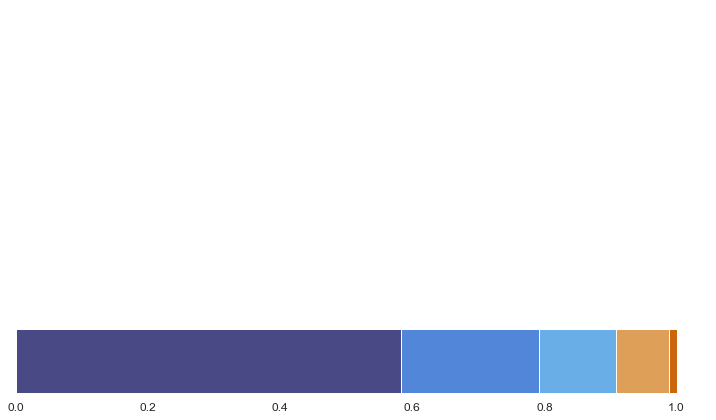

In [920]:
# Percentage of each category of travellers
fig, ax = plt.subplots(figsize = (20, 1))
pov_cat_count.T.plot.barh(stacked=True, figsize=(12,6), color = color_set, legend=None, ax = ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.yticks([]);
plt.ylim(bottom=0, top = 1.5);

## 4.3 Dataset deep dive

We are finally ready to do a deep dive into our dataset. We will focus on analysing key characteristics of visitor profiles (mainly based on purpose of visit).

### When do each category of visitors arrive? (Month of visit)

In [921]:
# Get only those pov categories with more than 50 records.
pov_vals_to_plot = (df_eda['pov_categorized'].value_counts()[df_eda['pov_categorized'].value_counts()>50]).index
df_eda_subset = df_eda[df_eda['pov_categorized'].isin(list(pov_vals_to_plot))]

Text(0.5, 22.960000000000136, 'Month')

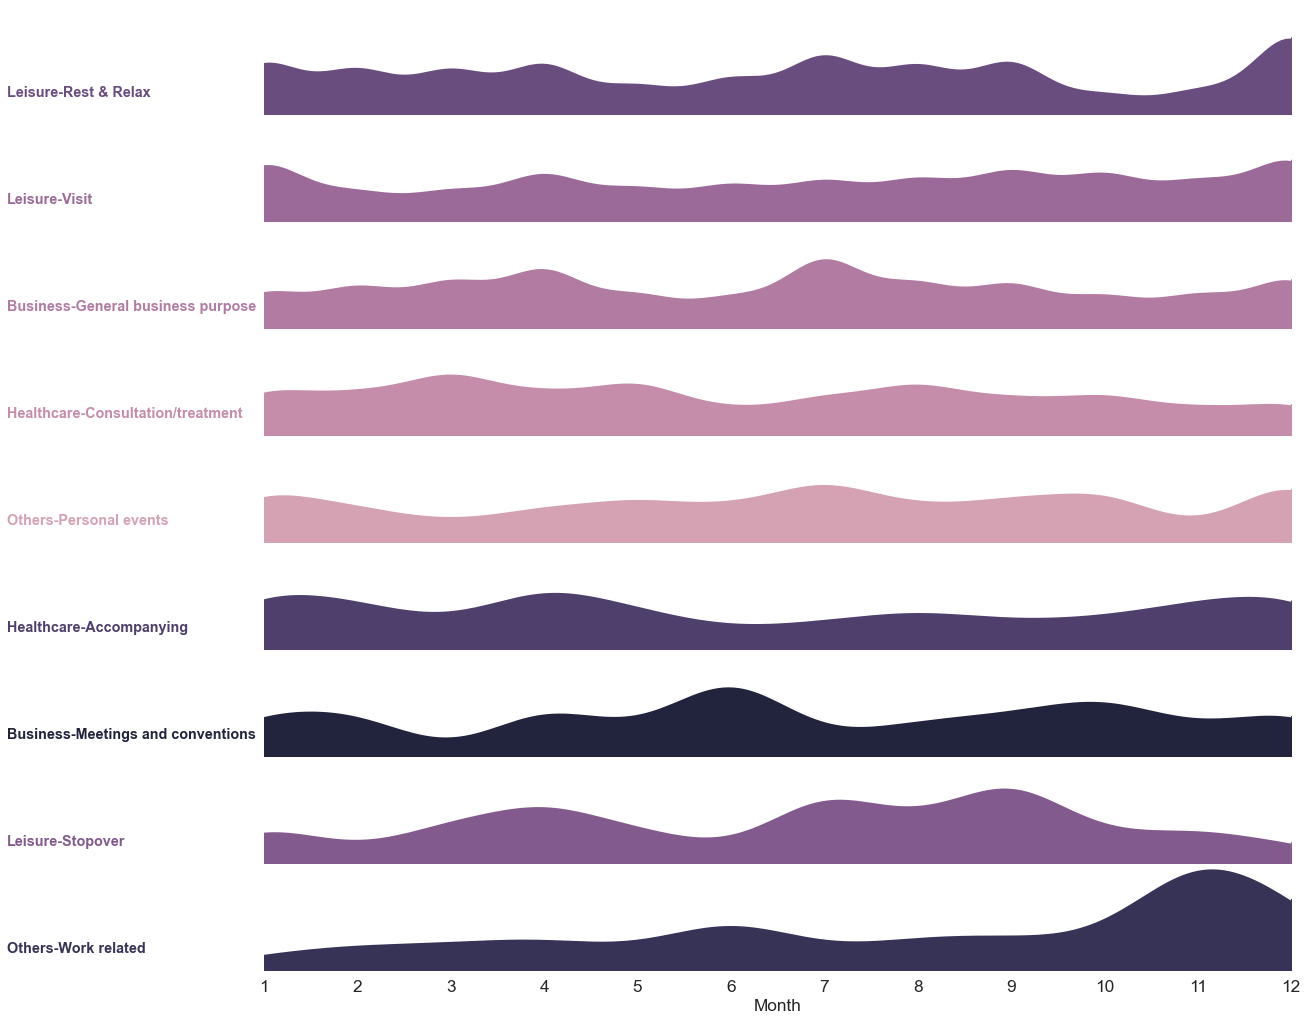

In [922]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(9, rot=0.5, light=.7, start = 2.7, hue = 0.7)
g = sns.FacetGrid(df_eda_subset, row="pov_categorized", row_order = df_eda_subset['pov_categorized'].value_counts().index, 
                  hue="pov_categorized", aspect=12, height=1.6, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "R.mth",
      bw_adjust=0.45, clip_on=True, cut = 0,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "R.mth", clip_on=True, cut = 0, color="w", lw=2, bw_adjust=.45)
# g.map(sns.histplot, "R.mth", kde = False, bins = 120, stat = 'probability')

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color='None', clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.25, .2, label, fontweight="bold", fontsize = 'large', color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "R.mth")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.xlim(1, 12);
plt.xticks(np.arange(1,13, 1.0), fontsize = 'x-large');
plt.xlabel('Month', fontsize = 'x-large')

### Age and Gender Profiles

In [923]:
# create a dictionary to store all categories with associated dataframe
pov_dict = {val: df_eda_subset[df_eda_subset["pov_categorized"]==val] for val in pov_vals_to_plot}

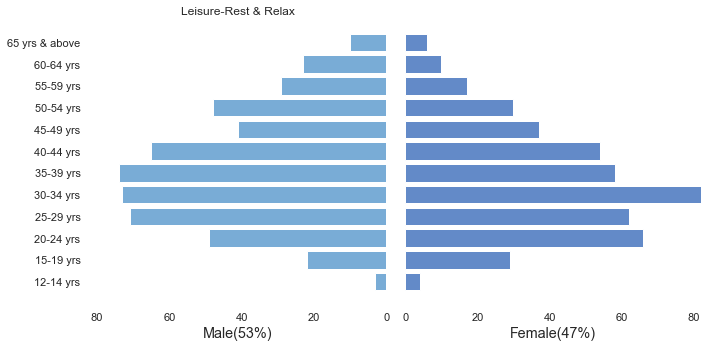

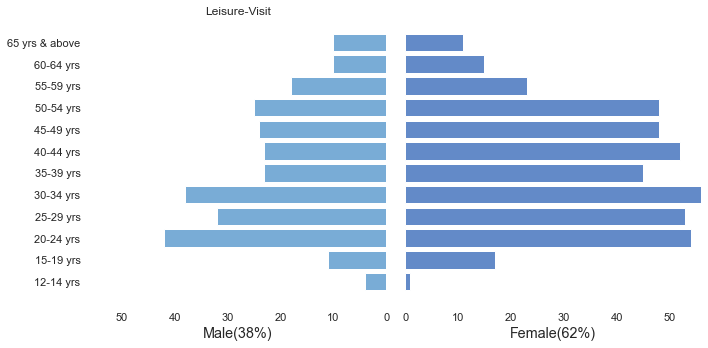

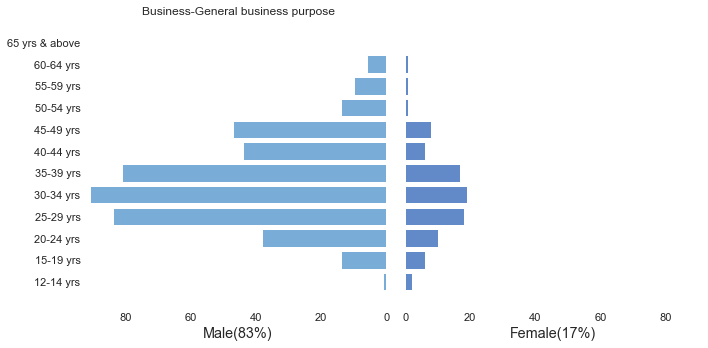

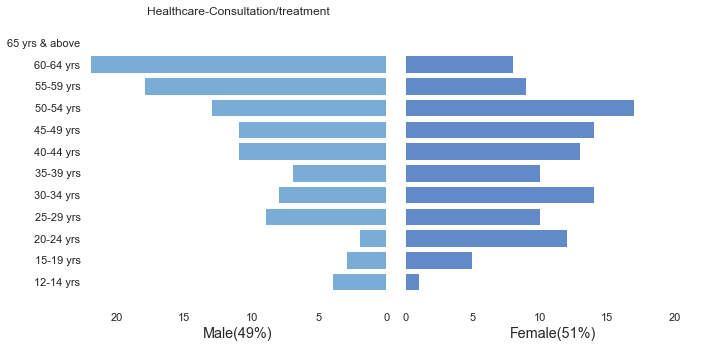

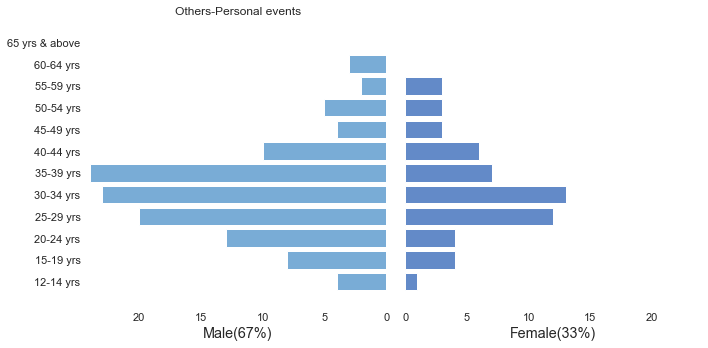

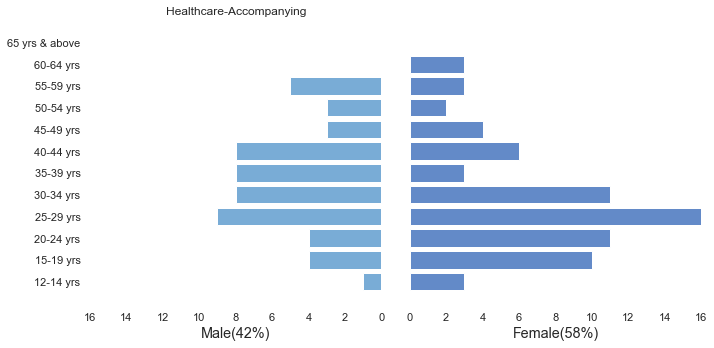

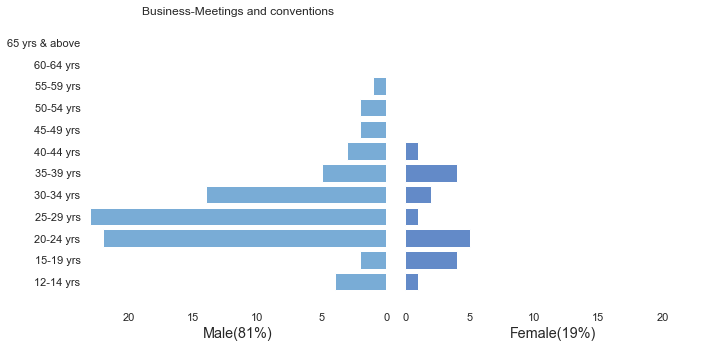

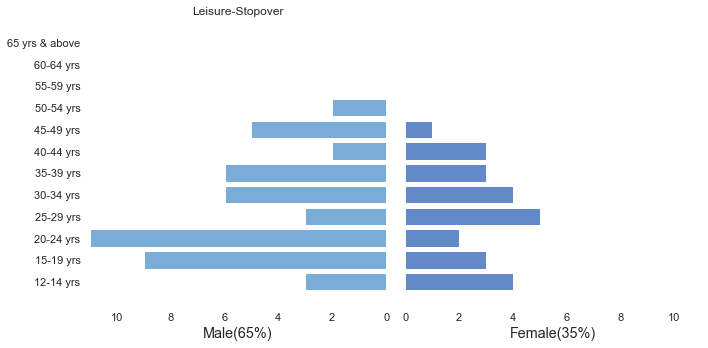

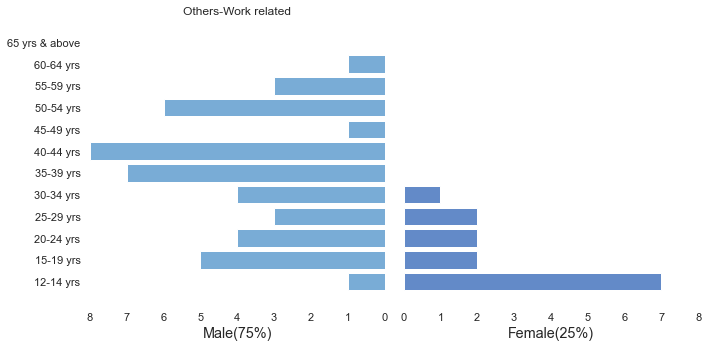

In [924]:
# plot population pyramid for each category
for k, v in pov_dict.items():
    population_pyramid(data = pov_dict[k], category = k, age_map = age_map, male_color = color_set[2], female_color = color_set[1])

### Number of Prior Visits

In [925]:
# map nbr_visit_map category to colors

def plot_pie(data, category, col):

    nbr_cats = df_eda_subset[col].unique()
    pal = sns.color_palette("deep").as_hex()
    color_dict = {cat: pal[i] for i, cat in enumerate(nbr_cats)}


    fig, ax = plt.subplots(figsize= (5,5))
    plt.pie(x = pov_dict[category][col].value_counts(normalize = True), labels = ((pov_dict[category][col].value_counts(normalize = True))*100).round(decimals = 1).astype(str) + '%',
           colors = [color_dict[v] for v in pov_dict[category][col].value_counts().keys()],labeldistance =1.05, counterclock=True)
    """plt.pie(x = pov_dict[category][col].value_counts(normalize = True), labels = (pov_dict[category][col].value_counts(normalize = True)).index,
           colors = [color_dict[v] for v in pov_dict[category][col].value_counts().keys()],labeldistance =1.05, counterclock=True)
    # Legend 
    plt.legend(facecolor='white', framealpha = 1)"""
    
    # Adding Circle in Pie chart
    cirle = plt.Circle((0, 0), 0.5, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(cirle)
    plt.title(k+f' ({data.shape[0]} records)')
    plt.tight_layout()

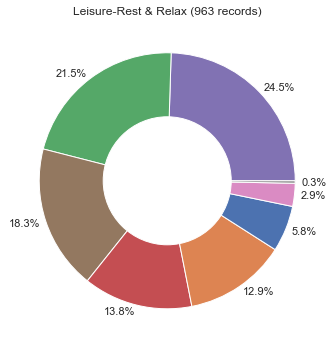

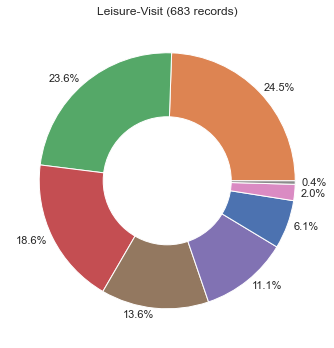

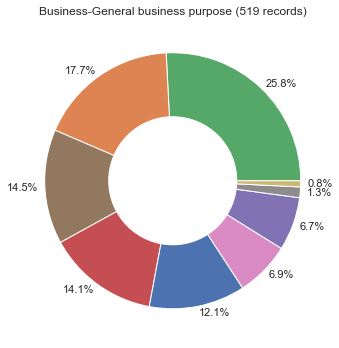

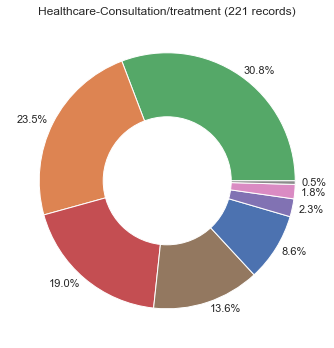

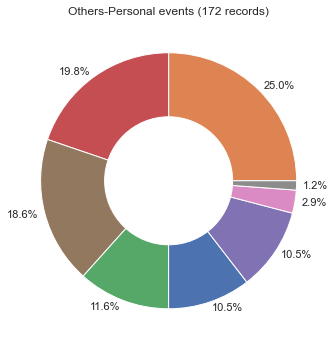

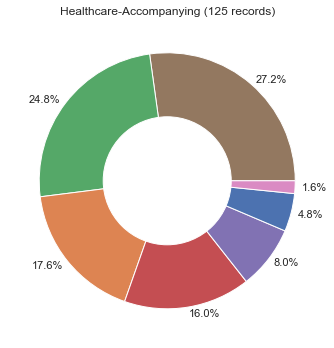

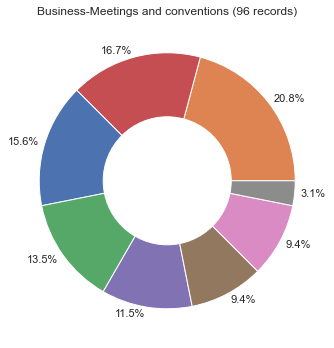

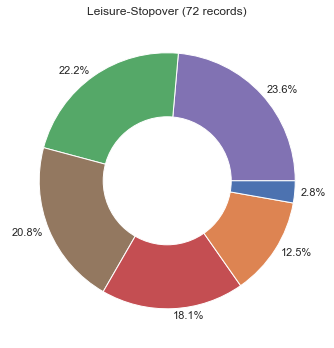

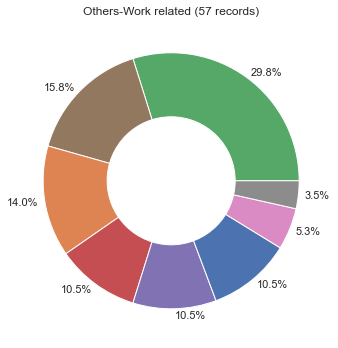

In [926]:
for k, v in pov_dict.items():
    plot_pie(data = pov_dict[k], category = k, col = 'nbr_visit_map')

### Companions

In [927]:
companions_vals_to_plot = (df_eda['companions'].value_counts()[df_eda['companions'].value_counts()>50]).index
companions_dict = {val: df_eda_subset[df_eda_subset["companions"]==val] for val in companions_vals_to_plot}

In [928]:
# Plot quantile plot
def quantile_plot(df_dict, price_category, palette, quantiles = (0.1, 0.9), sum_plot = False):

    fig, axes = plt.subplots(1, 5, figsize = (20, 10), sharex=True)
    
    pal = sns.color_palette(palette).as_hex()
    
    count= 0 
    for cat, df in df_dict.items():
        
        # get a pivot table with median, and percentiles
        data = df.groupby(by = 'pov_categorized_int').agg({"pov_categorized": 'first', 
                                                    price_category: [np.sum, np.median, 
                                                                                lambda x: x.quantile(quantiles[0]),
                                                                                lambda x: x.quantile(quantiles[1])]})
        data.columns = data.columns.droplevel()
        data = data.reset_index()
        #data = data.melt(id_vars = ['pov_categorized_int', 'first'])
        
        if sum_plot == False: 
            # bottom percentile
            sns.scatterplot(data = data, x = '<lambda_0>', y = 'pov_categorized_int', ax = axes[count],
                           color = pal[0], s = 150, alpha = 0.9, legend=False)
            # top percentile
            sns.scatterplot(data = data, x = '<lambda_1>', y = 'pov_categorized_int', ax = axes[count],
                           color = pal[-1], s = 150, alpha = 0.5, legend=False)
            # median
            sns.scatterplot(data = data, x = 'median', y = 'pov_categorized_int', ax = axes[count],
                           color = pal[len(pal)//2], s = 300, alpha = 0.8, legend=False)
        else:
            sns.scatterplot(data = data, x = 'sum', y = 'pov_categorized_int', ax = axes[count],
                           color = pal[len(pal)//2], s = 300, alpha = 1, legend=False)


        # set x label as campanion category
        axes[count].set_xlabel(cat, fontsize = 'x-large')
        # invert y axis
        #axes[count].set_xlim(0, 2050)
        axes[count].set_ylim(axes[count].get_ylim()[::-1])

        # map y_ticks to string for left plot
        if count==0:
            pov_int_map = {i: v for i, v in enumerate(df_eda_subset['pov_categorized'].value_counts().index)}
            axes[count].set_yticks([k for k, v in pov_int_map.items()])
            axes[count].set_yticklabels([v for k, v in pov_int_map.items()])
        else: 
            axes[count].set_yticklabels([])

        axes[count].set_ylabel("")
        axes[count].xaxis.grid(True)
        axes[count].yaxis.grid(True)
        sns.despine(bottom=True, left=True)
        fig.suptitle(price_category)

        count+=1

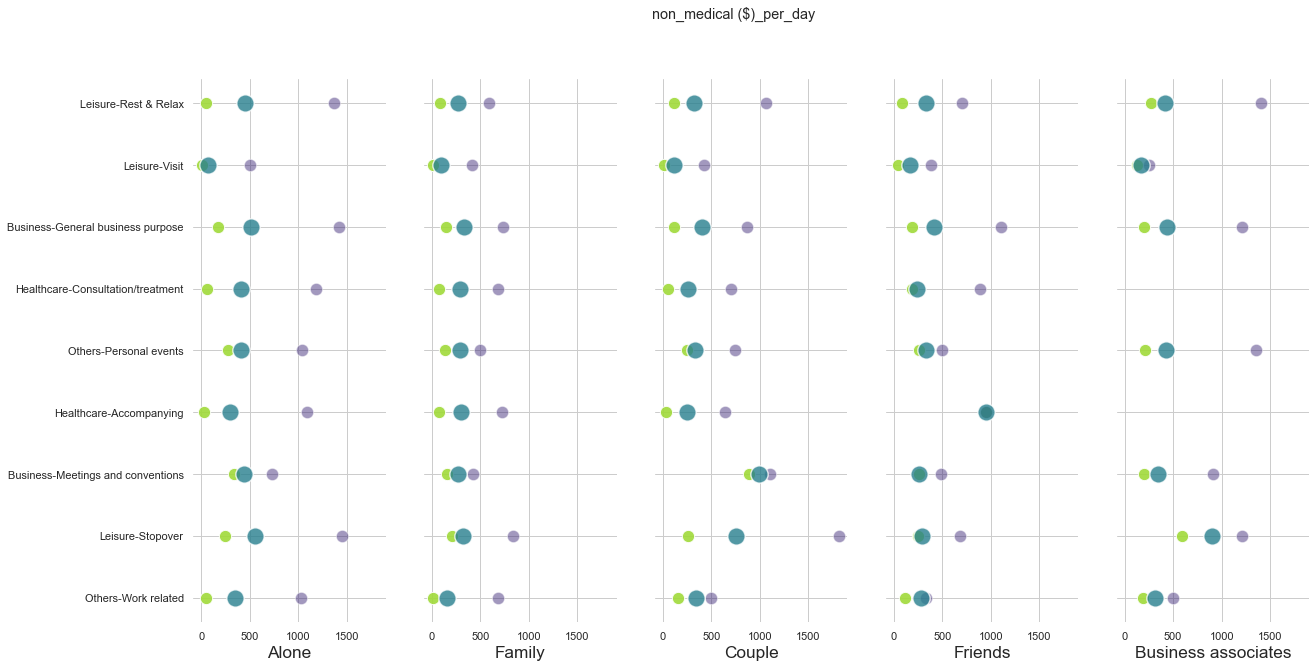

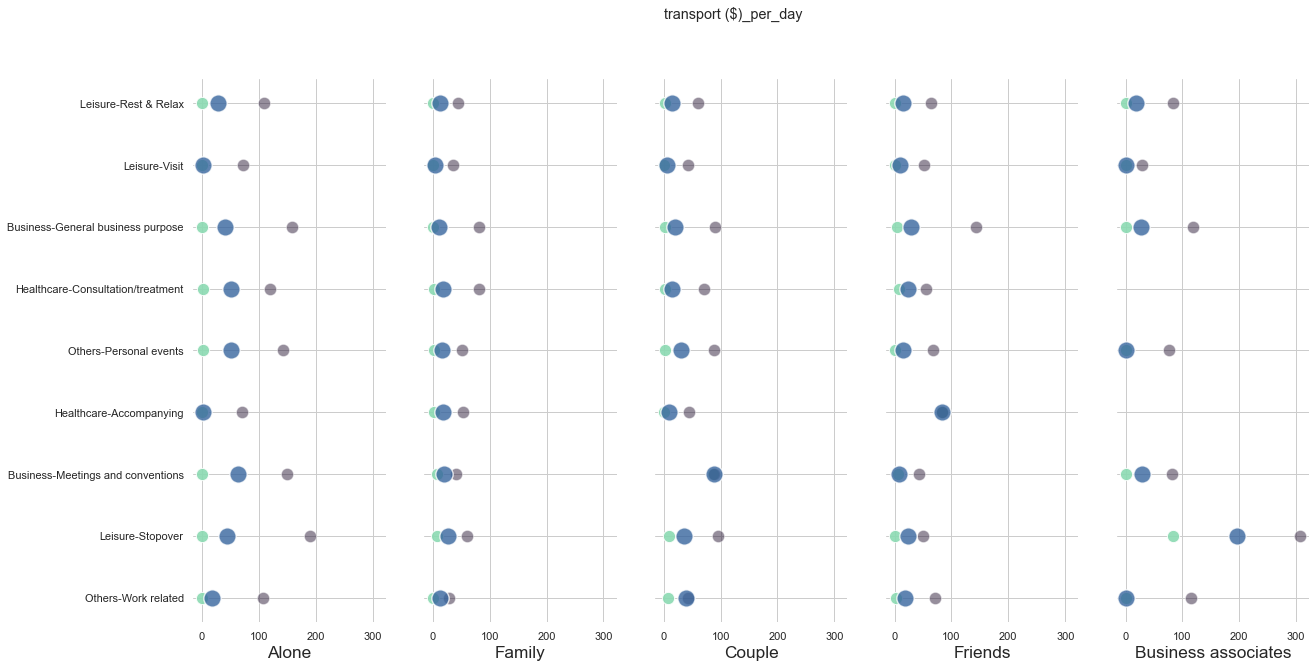

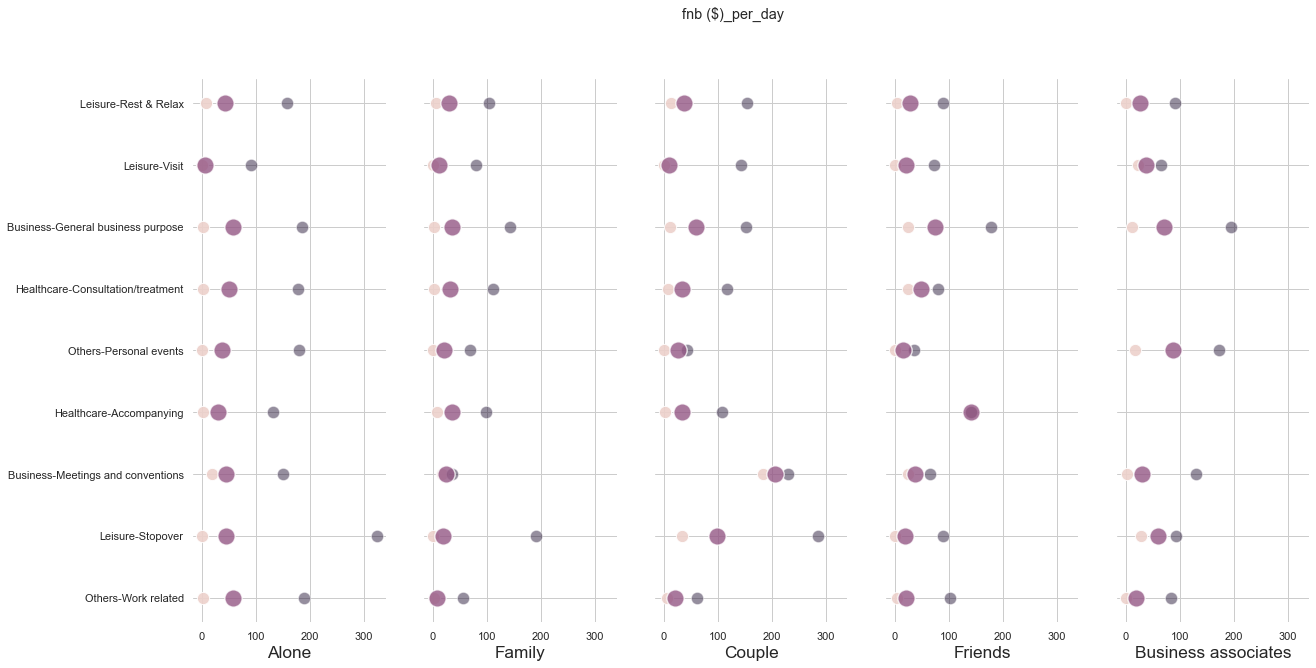

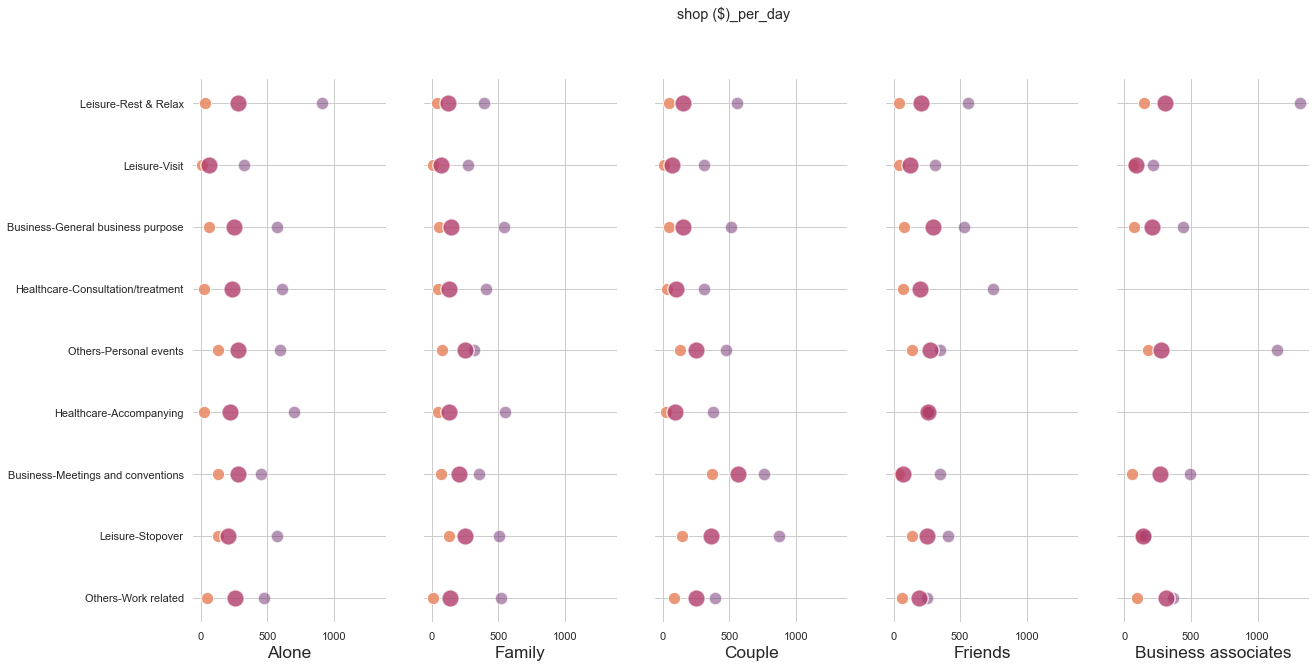

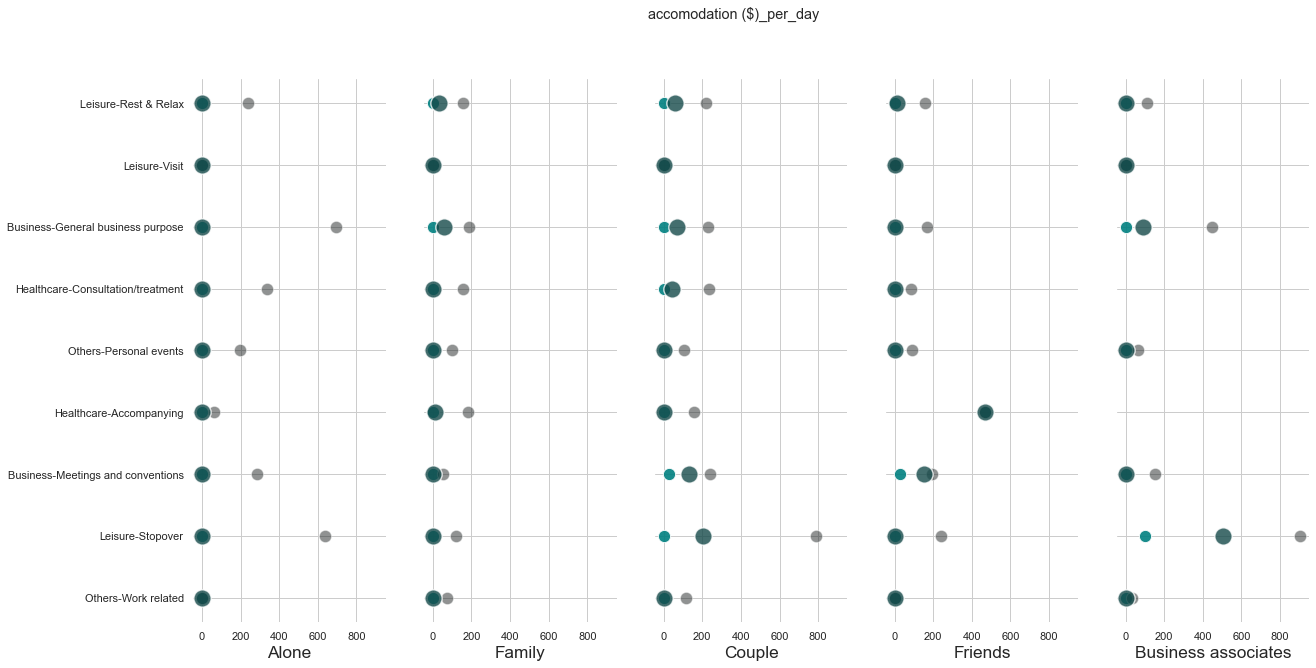

In [932]:
category_color_map = {'non_medical ($)_per_day': 'viridis_r', 'transport ($)_per_day': "mako_r", 
                      'fnb ($)_per_day': sns.cubehelix_palette(), 'shop ($)_per_day': 'flare', 'accomodation ($)_per_day': sns.dark_palette("teal", reverse = True)
                     }

# plot daily receipt
for k,v in category_color_map.items(): 
    quantile_plot(df_dict = companions_dict, price_category = k, palette=v, quantiles = (0.1, 0.9))

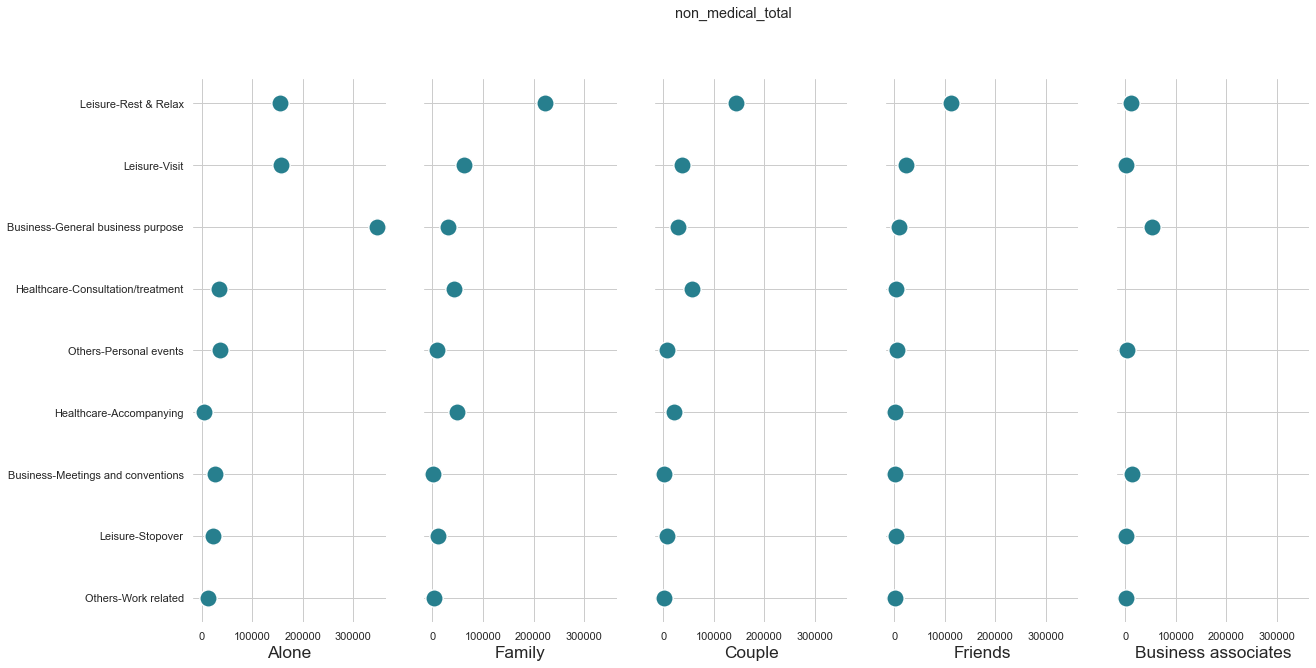

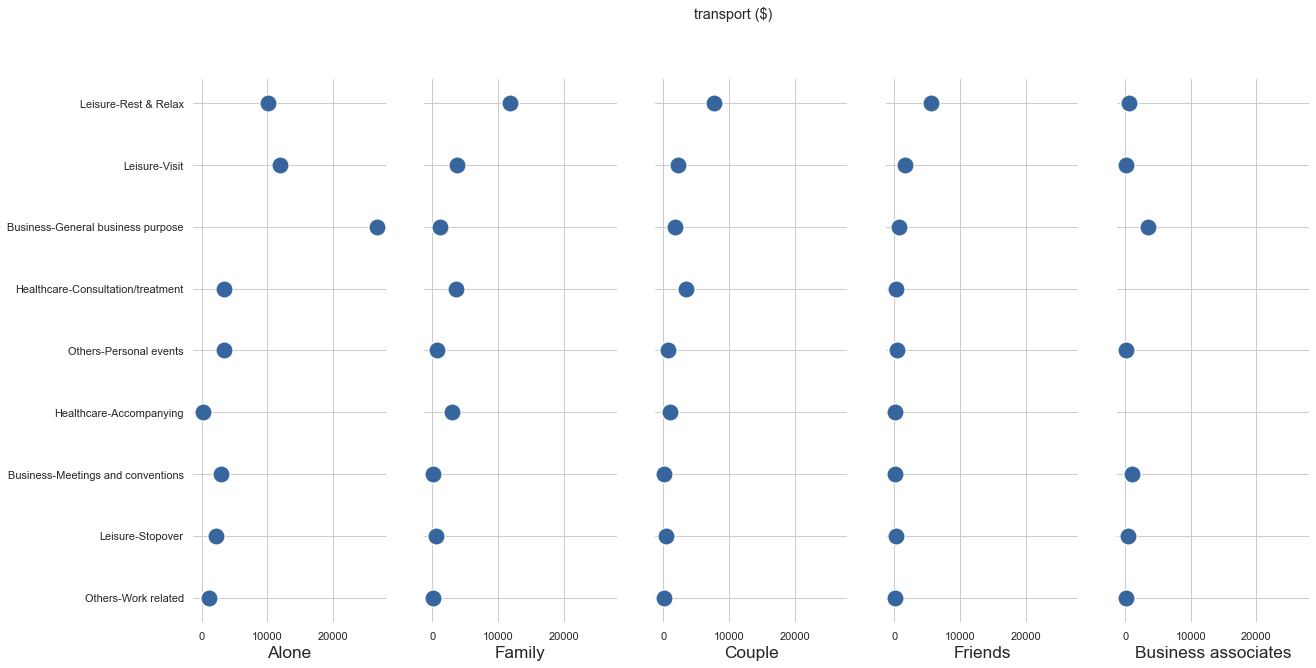

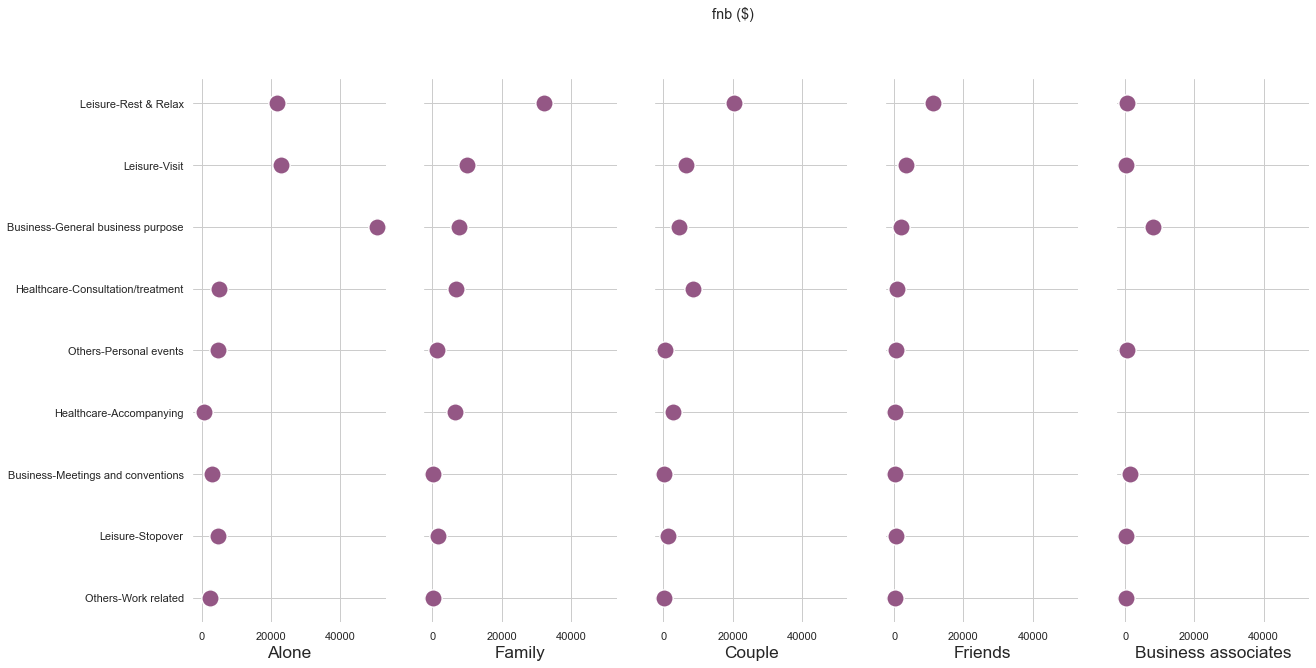

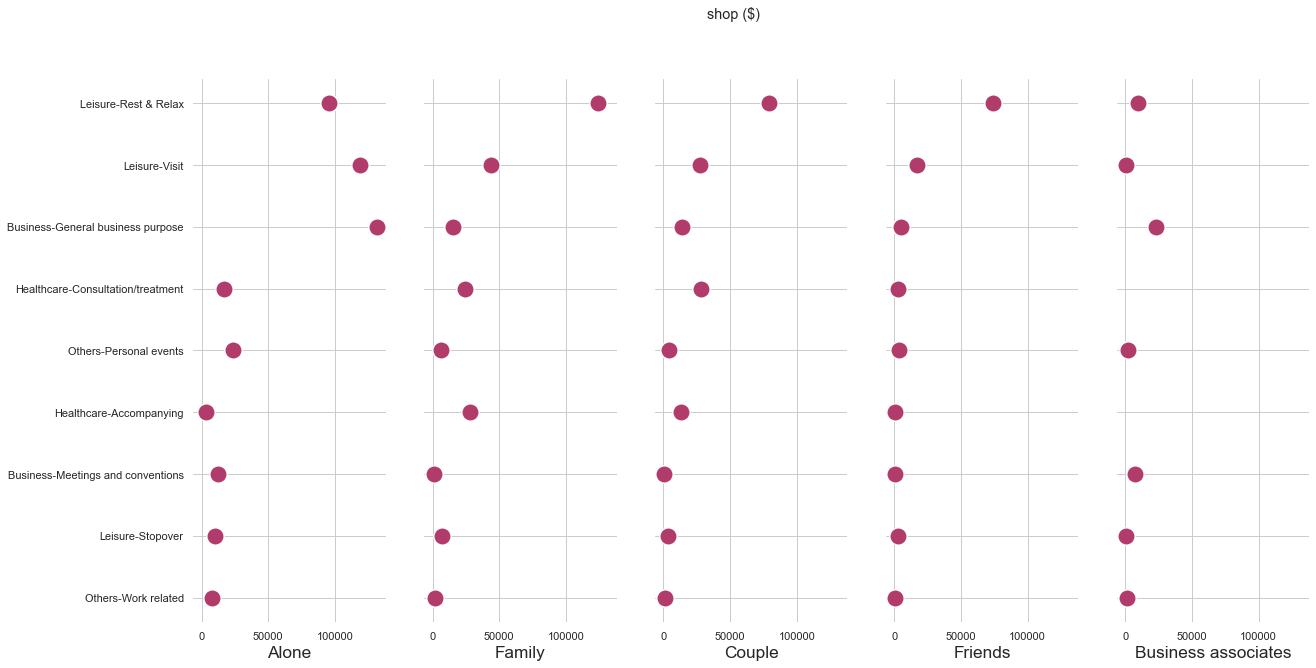

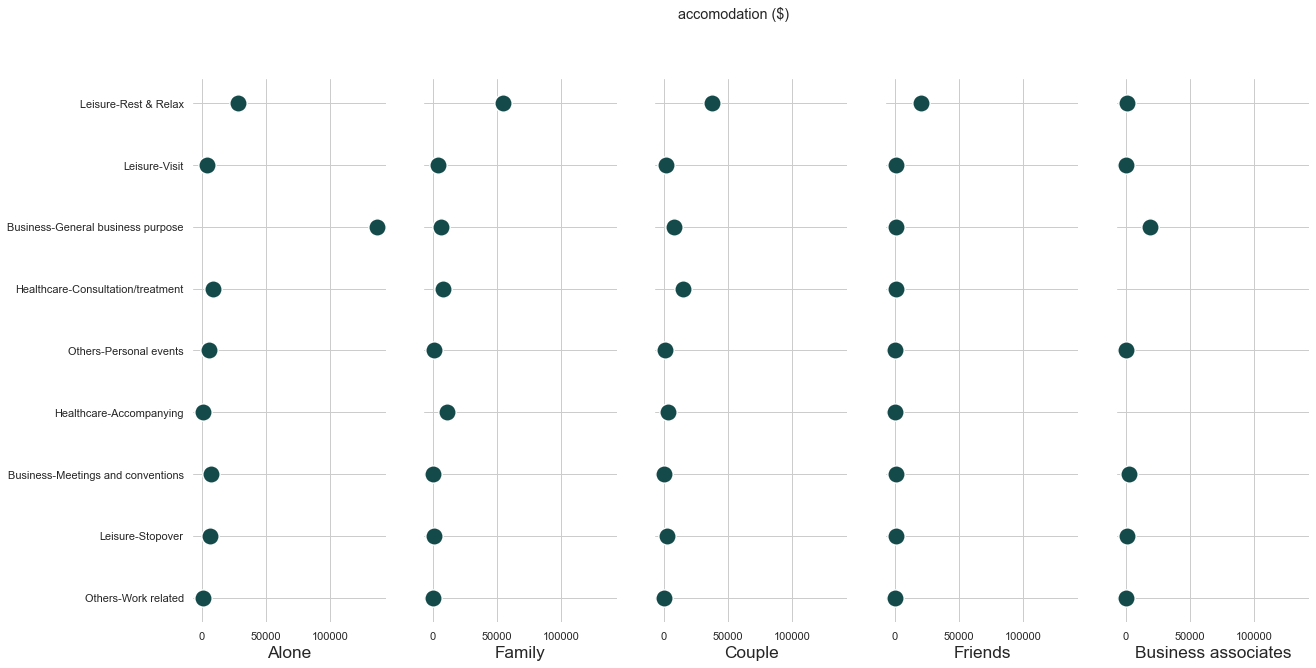

In [934]:
category_color_map = {'non_medical_total': 'viridis_r', 'transport ($)': "mako_r", 
                      'fnb ($)': sns.cubehelix_palette(), 'shop ($)': 'flare', 'accomodation ($)': sns.dark_palette("teal", reverse = True)
                     }

# plot total yearly receipt
for k,v in category_color_map.items(): 
    quantile_plot(df_dict = companions_dict, price_category = k, palette=v, quantiles = (0.1, 0.9), sum_plot=True)

# 5 What effects how much the visitors spend? (Regression Modelling)

Now we will find what are the influences to the visitor spending. We will define the response variable as daily non-medical spending. We will select features and run them through our regression model, and obtain coefficients which will give us a sense of the importance of each feature in influencing spending. 

## 5.1 Preparing the dataset for modelling

In [1068]:
# Define how to treat different columns

cols_to_drop = ['quarter', 'Last Port', 'Next Port', 'accomodation ($)', 'shop ($)', 'fnb ($)', 'transport ($)', 
                'medical ($)', 'others ($)', 'pov_categorized_general', 'pov_categorized_int', 'age_map', 'nbr_visit_map',
               'accomodation ($)_per_day', 'shop ($)_per_day', 'fnb ($)_per_day', 'transport ($)_per_day', 'medical ($)_per_day',
               'others ($)_per_day', 'Total_per_day', 'Total', 'non_medical_total']
cols_to_binary_encode = ['1st time visitor', 'gender']
cols_to_one_hot = ['R.mth', 'age', 'Mono-SIN', 'Travel Type', 'marital status', 'companions', 'pov_categorized', 'carrier_category']

In [1069]:
# Drop unselected columns
df_modelling = df_eda_subset.drop(columns=cols_to_drop)

In [1070]:
# binary encode some columns
def binary_encode(row):
    row['1st time visitor'] = 1 if row['1st time visitor'] == 'Yes' else 0
    row['gender'] = 1 if row['gender'] == 'Female' else 0
    return row
df_modelling = df_modelling.apply(binary_encode, axis = 1)

In [1071]:
# One hot encode some columns
df_modelling = pd.get_dummies(data = df_modelling, columns = cols_to_one_hot, drop_first = True)

In [1072]:
print(df_modelling.shape)
df_modelling.head(3)

(2908, 54)


,1st time visitor,nbr visit past 3 yrs,length of stay,gender,non_medical ($)_per_day,R.mth_2,R.mth_3,R.mth_4,R.mth_5,R.mth_6,R.mth_7,R.mth_8,R.mth_9,R.mth_10,R.mth_11,R.mth_12,age_15-19 yrs,age_20-24 yrs,age_25-29 yrs,age_30-34 yrs,age_35-39 yrs,age_40-44 yrs,age_45-49 yrs,age_50-54 yrs,age_55-59 yrs,age_60-64 yrs,age_65 yrs & above,Mono-SIN_Multi-Destination,Mono-SIN_Not Stated,Travel Type_FIT,Travel Type_Pkg,marital status_divorced,marital status_married,marital status_single,marital status_widowed,companions_Business associates,companions_Couple,companions_Family,companions_Friends,companions_Others,pov_categorized_Business-Meetings and conventions,pov_categorized_Healthcare-Accompanying,pov_categorized_Healthcare-Consultation/treatment,pov_categorized_Leisure-Rest & Relax,pov_categorized_Leisure-Stopover,pov_categorized_Leisure-Visit,pov_categorized_Others-Personal events,pov_categorized_Others-Work related,carrier_category_Low Cost Carrier,carrier_category_National Carrier,carrier_category_Others,carrier_category_Premium Carrier,carrier_category_Regional Carrier,carrier_category_Sea
0,0,50,0.5,0,388.235411,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,18,1.0,0,1353.754370,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,0,3,1.0,0,2646.062594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [1075]:
# Transform 3 columns with boxcox transformation
features_to_transform = ['nbr visit past 3 yrs', 'length of stay', 'non_medical ($)_per_day']

y_lambda = [] # the lambda value used for box cox
transformed_features = df_modelling[features_to_transform].apply(boxcox_transform) # apply the transformation

# drop original selected columns and concat transformed columns to df
df_modelling_t_temp = df_modelling.drop(features_to_transform, axis = 1)
df_modelling_t = pd.concat([df_modelling_t_temp, transformed_features], axis = 1)

In [1089]:
# To plot the features after boxcox transformation
# plot_hist(df_modelling_t[features_to_transform])

In [1076]:
# Set X and y
X = df_modelling_t.drop('non_medical ($)_per_day', axis = 1)
y = df_modelling_t['non_medical ($)_per_day']

## 5.2 Regression Modeling

In [1093]:
# We will first run some linear regression models

import warnings
warnings.filterwarnings('ignore')

estimators_lin = {
    "linear": {'estimator':LinearRegression(), 'params': {}}, 
    "ridge": {'estimator': Ridge(), 'params': {"ridge__alpha": np.logspace(-1,5,100)}}, 
    "lasso": {'estimator': Lasso(), 'params': {"lasso__alpha": np.logspace(-4,1,10)}}, 
    "enet": {'estimator': ElasticNet(), "params": {"enet__alpha": np.linspace(0.1, 1.0, 10), "enet__l1_ratio": np.linspace(0.1, 1, 10)}},
    "knn": {"estimator": KNeighborsRegressor(), "params": {"knn__n_neighbors": [3, 5, 7, 9, 11, 21, 31, 41, 51, 101], "knn__weights": ['uniform', 'distance']}}
}

# Linear regressors
scoring = ['neg_mean_absolute_error'] # gridsearch scoring functions
grid_search_result_R1 = hyperparam_tuning(feature_sets = {0:X}, response = y, 
                                        estimators = estimators_lin, use_PCA = False, useSMOTE = False, scaler = StandardScaler(),
                                        scoring = scoring, refit = 'neg_mean_absolute_error', cv = 5, verbose = 0)

------------------- Feature Set 0 --------------------
linear best neg_mean_absolute_error score: -1525592587819.1782
ridge best neg_mean_absolute_error score: -0.9142618359808816
lasso best neg_mean_absolute_error score: -0.9031505791352169
enet best neg_mean_absolute_error score: -0.9120009402211073
knn best neg_mean_absolute_error score: -1.2742791022468012


## 5.3 Modelling evaluation and top predictors of daily non-medical spent

### Model evaluation

In [1080]:
# View the gridsearch results
cv_df = pd.DataFrame(grid_search_result_R1)
cv_df

,feature_set,estimator,grid search object,best estimator,best score,best params
0,0,linear,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",-1.525593e+12,{}
1,0,ridge,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=93.260334688321...",-9.142618e-01,{'ridge__alpha': 93.26033468832199}
2,0,lasso,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Lasso(alpha=0.0166810053720...",-9.031506e-01,{'lasso__alpha': 0.016681005372000592}
3,0,enet,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), ElasticNet(alpha=0.1, l1_ra...",-9.120009e-01,"{'enet__alpha': 0.1, 'enet__l1_ratio': 0.2}"
4,0,knn,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(n_neigh...",-1.274279e+00,"{'knn__n_neighbors': 51, 'knn__weights': 'dist..."


### Feature importances by looking at coefficients

In [1084]:
feature_impt_reg = pd.DataFrame({'Feature':X.columns, 'Feature Importance': cv_df[cv_df['estimator']=='lasso']['best estimator'].values[0][1].coef_}).sort_values(by = 'Feature Importance', ascending = False)
feature_impt_reg = feature_impt_reg.reset_index(drop = True)
feature_impt_reg

,Feature,Feature Importance
0,carrier_category_Premium Carrier,0.174717
1,carrier_category_National Carrier,0.166638
2,nbr visit past 3 yrs,0.126153
3,companions_Others,0.077232
4,R.mth_8,0.045301
5,Travel Type_Pkg,0.032363
6,age_30-34 yrs,0.018316
7,marital status_married,0.016400
8,age_40-44 yrs,0.015518
9,carrier_category_Regional Carrier,0.013882
